In [13]:
import astropy.constants as const
import numpy as np
import yaml
import matplotlib.pyplot as plt

m_e = (const.m_e.cgs).value
m_p = (const.m_p.cgs).value
e = (const.e.esu).value
c = (const.c.cgs).value
pi = np.pi
r_e = e**2/(m_e*c**2) 
sigma_e = 8*pi/3*r_e**2

with open('/home/wsy/Acc_MC/MC_sim/paras.yaml', 'r') as f:
    config = yaml.safe_load(f)
R_sh = float(config['R_sh'])
GM0 = float(config['GM0'])
eta = float(config['eta'])
beta_min = float(config['beta_min'])
B0 = float(config['B0'])
xi = float(config['xi'])
Lam_max = float(config['Lam_max'])
g_me0 = float(config['g_me0']) 
r0 = float(config['r0'])
n_p = float(config['n_p'])
mode = float(config['mode'])

N_par = int(config['N_par']) # 粒子数
N_time = int(float((config['N_time']))) # 时间步数
N_bins = config['N_bins'] # 时间步长

jet_type = config['type']
syn = config['SYN_flag']
SA = config['SA_flag']
Sh = config['Shear_flag']


if jet_type=='kolgv': 
    q = 5/3
elif jet_type=='Bohm':
    q = 1
elif jet_type=='HS':
    q = 2
else:
    raise ValueError("The input should be meaningful")

# 喷流截面速度分布
def beta_dis(r, GM_0, r_max):
    r1 = eta*r_max
    beta_max = np.sqrt(1-1/GM_0**2)
    if np.abs(r)<r1:
        return beta_max
    elif np.abs(r)>r_max:
        return 0.0
    else:
        return beta_max + ((beta_min-beta_max)/(r_max-r1))*(np.abs(r)-r1)

# 散射时标
def T_sc(B0,gme):
    A_sc = xi**(-1)*Lam_max**(q-1)*c**(-1)*(m_e*np.square(c)/(e*B0))**(2-q)
    t_sc = A_sc*gme**(2-q)
    return t_sc

# 同步辐射能损
def T_cool(B0,gme):
    A2 = (sigma_e*np.square(B0))/(6*pi*m_e*c)
    t_cool = (A2*gme)**(-1)
    return t_cool

# 扩散逃逸时标
def T_esc(B0,gme):
    A_sc = xi**(-1)*Lam_max**(q-1)*c**(-1)*(m_e*np.square(c)/(e*B0))**(2-q)
    A3 = ((3*np.square(R_sh))/(np.square(c)))*A_sc**(-1)
    t_esc = A3*gme**(q-2)
    return t_esc

# 随机加速时标
def T_SA(B0, n_p, gme):
    rg = gme*m_e*c**2/(e*B0)
    ba = B0 / np.sqrt(B0**2 + 4 * pi * n_p * m_p * c**2) # 相对喷流随动系的Alfven波波速
    Dpp = xi * ba**2 / (1 - ba**2) * g_me0**2 * c / rg**(2 - q) / Lam_max**(q - 1) # Dpp
    tacc = g_me0**2 / Dpp
    return tacc

# NR剪切加速时标
def T_sh(B0,gme):
    beta0 = beta_dis(0,GM0,R_sh) #中心流速
    beta = beta_dis(r0,GM0,R_sh) #注入位置流速
    rate = 1- eta # 剪切区域比例
    Delta_r = rate*R_sh
    A_sc = xi**(-1)*Lam_max**(q-1)*c**(-1)*(m_e*np.square(c)/(e*B0))**(2-q)
    Gamma_j4 = 1/(1-beta**2)**2
    A1=(2/15)*Gamma_j4*np.square(c*(beta0/Delta_r))*A_sc
    t_sh = 2*gme**(q-2)/(A1*(6-q))
    return t_sh

# 回旋半径
def rg(B0,gme):
    return gme*m_e*c**2/(e*B0)

# Alfven波波速
def Alf_beta(B0,n_p):
    ba = B0 / np.sqrt(B0**2 + 4 * pi * n_p * m_p * c**2)
    return ba

In [14]:
print(Alf_beta(3e-6,1e-7))
print('Scattering timescale: %s'%T_sc(B0, g_me0))
print(T_SA(B0,n_p,g_me0))

0.06885962333340202
Scattering timescale: 1282346.2725925432
269160830192.06317


0.002182708264139581


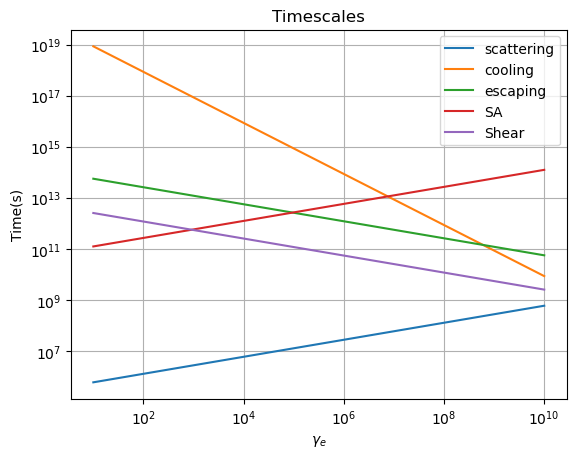

In [15]:
gme_list = np.logspace(1,10,100)
t_sc = T_sc(B0,gme_list)
t_cool = T_cool(B0,gme_list)
t_esc = T_esc(B0,gme_list)
t_acc = T_SA(B0,n_p,gme_list)
t_sh = T_sh(B0,gme_list)
rg = rg(B0, gme_list)
ba = Alf_beta(B0,n_p)
print(ba)
#print(c*t_sc)
#print(rg)
plt.title('Timescales')
plt.plot(gme_list,t_sc,label='scattering')
plt.plot(gme_list,t_cool,label = 'cooling')
plt.plot(gme_list,t_esc,label = 'escaping')
plt.plot(gme_list,t_acc,label='SA')
plt.plot(gme_list,t_sh,label='Shear')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\gamma_e$')
plt.ylabel('Time(s)')
plt.grid(True)
plt.legend()
plt.show()

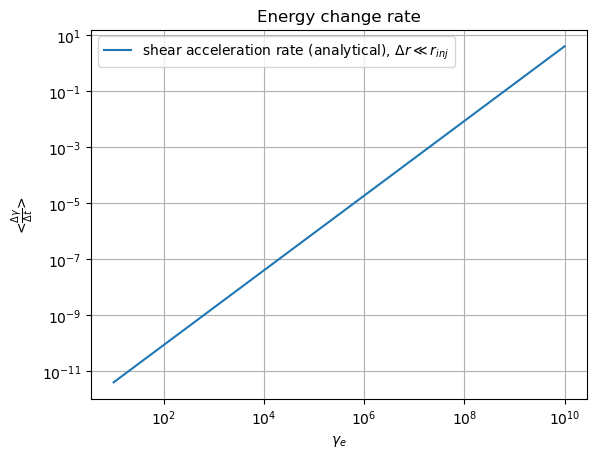

In [16]:
plt.title('Energy change rate')
plt.plot(gme_list,gme_list/t_sh,label=r'shear acceleration rate (analytical), $\Delta r \ll r_{inj}$')
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\gamma_e$')
plt.ylabel(r'<$\frac{\Delta \gamma}{\Delta t}$>')
plt.grid(True)
plt.legend()
plt.show()